In [2]:
%load_ext autoreload
%autoreload 2

In [115]:
import cvxpy as cp
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from pideq.deq.model import DEQ

from sklearn.linear_model import LinearRegression

### Data

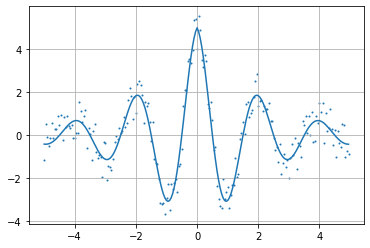

In [7]:
f_true = lambda u: 5 * np.cos(np.pi * u) * np.exp(-np.abs(u) / 2)
def f(u):
    w = 2 * np.random.rand(*u.shape) - 1
    return f_true(u) + w

u = np.arange(-5, 5, 10 / 200)

plt.plot(u, f_true(u))
plt.scatter(u, f(u), s=1)
plt.grid()
plt.show()

### NN

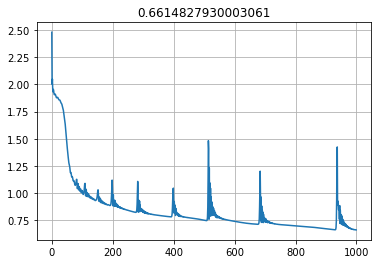

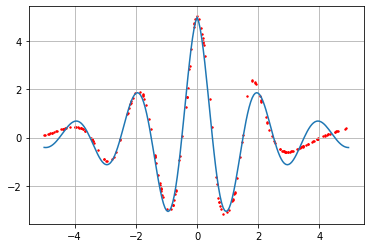

In [42]:
net = nn.Sequential(
    nn.Linear(1,25),
    nn.Tanh(),
    nn.Linear(25,25),
    nn.Tanh(),
    nn.Linear(25,25),
    nn.Tanh(),
    nn.Linear(25,1),
)

U = 10 * torch.rand(200, 1) - 5
U = U.float()
Y = torch.from_numpy(f(U.numpy())).float()

criteria = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), 1e-2)

losses = list()

U.requires_grad_()
for _ in range(1000):
    optim.zero_grad()

    Y_hat = 6 * net(U)

    loss = criteria(Y, Y_hat)
    losses.append(loss.item())

    loss.backward()
    optim.step()

plt.plot(np.sqrt(losses))
plt.gca().set_title(np.sqrt(losses[-1]))
plt.grid()
plt.show()

y_hat = Y_hat.detach().numpy()
plt.plot(u, f_true(u))
plt.scatter(U.detach().numpy(), Y_hat.detach().numpy(), s=2, c='red')
plt.grid()
plt.show()

### Implicit Model

#### Without any regularization

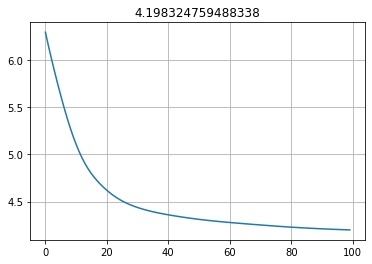

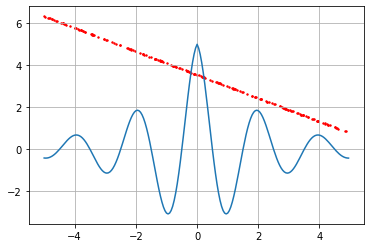

In [49]:
deq = DEQ(n_states=75, compute_jac_loss=False)

criteria = nn.MSELoss()
optim = torch.optim.SGD([deq.A.weight, deq.A.bias, deq.B.weight, deq.B.bias], 1e-2)

losses = list()
for _ in range(1000):
    optim.zero_grad()

    Y_hat = 6 * deq(U)

    loss = criteria(Y, Y_hat)
    losses.append(loss.item())

    loss.backward()
    optim.step()

plt.plot(np.sqrt(losses))
plt.gca().set_title(np.sqrt(losses[-1]))
plt.grid()
plt.show()

y_hat = Y_hat.detach().numpy()
plt.plot(u, f_true(u))
plt.scatter(U.detach().numpy(), Y_hat.detach().numpy(), s=2, c='red')
plt.grid()
plt.show()

#### With projection

/home/bruno/miniconda3/envs/pideq/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


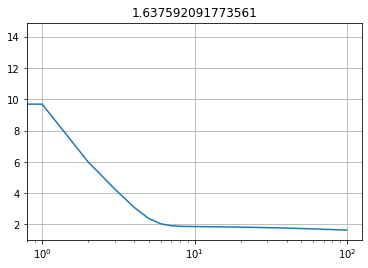

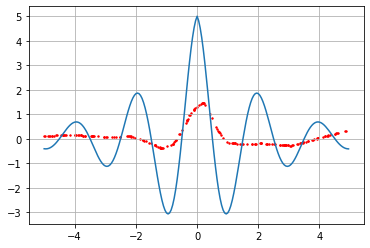

In [132]:
deq = DEQ(n_states=75, phi=torch.relu, compute_jac_loss=False, weight_initialization_factor=1)
kappa = .9

criteria = nn.MSELoss()
optim = torch.optim.SGD([deq.A.weight, deq.A.bias, deq.B.weight, deq.B.bias], 1e-3)
# optim = torch.optim.SGD(deq.parameters(), 1e-3)

losses = list()

# define parametrized optimization problem
a0 = cp.Parameter(deq.A.weight.shape[0]+1, complex=False)
a = cp.Variable(deq.A.weight.shape[0]+1, complex=False)
constraint = [cp.norm(a, p=1) <= kappa - 1e-3,]

prob = cp.Problem(cp.Minimize(cp.norm(a - a0, p=2)), constraint)

for _ in range(100):
    optim.zero_grad()

    Y_hat = 6 * deq(U)

    loss = criteria(Y, Y_hat)
    losses.append(loss.item())

    loss.backward()
    optim.step()

    # projection
    A0 = np.hstack([  # considering the bias for state x_ = (x,1)
        deq.A.weight.data.detach().numpy(),
        deq.A.bias.data.detach().numpy()[...,None],
    ])
    A_rows = list()
    for i in range(A0.shape[0]):
        a0.value = A0[i]
        try:
            prob.solve(verbose=False)
            A_rows.append(a.value)
        except cp.SolverError:
            A_rows.append(A0[i])
    A = np.vstack(A_rows)

    deq.A.weight.data.copy_(torch.from_numpy(A[:,:-1]).to(deq.A.weight.data))
    deq.A.bias.data.copy_(torch.from_numpy(A[:,-1]).to(deq.A.bias.data))

plt.plot(np.sqrt(losses))
plt.gca().set_title(np.sqrt(losses[-1]))
plt.xscale('log')
plt.grid()
plt.show()

y_hat = Y_hat.detach().numpy()
plt.plot(u, f_true(u))
plt.scatter(U.detach().numpy(), Y_hat.detach().numpy(), s=2, c='red')
plt.grid()
plt.show()

0.6015422124042622


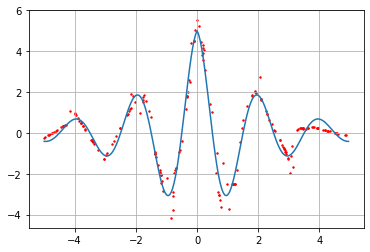

In [134]:
tmp_deq = DEQ(n_states=75, n_out=75, phi=torch.relu, compute_jac_loss=False, weight_initialization_factor=1)
tmp_deq.A = deq.A
tmp_deq.B = deq.B
tmp_deq.C.weight.data = torch.eye(75).to(tmp_deq.C.weight.data)
tmp_deq.C.bias.data = torch.zeros_like(tmp_deq.C.bias.data)
tmp_deq.D.weight.data = torch.zeros_like(tmp_deq.D.weight.data)
tmp_deq.D.bias.data = torch.zeros_like(tmp_deq.D.bias.data)

Z_hat = tmp_deq(U)
Y_hat_tmp = 6 * (deq.C(Z_hat) + deq.D(U))
Y_hat = 6 * deq(U)
assert (Y_hat == Y_hat_tmp).all()

z_hat = np.hstack([
    Z_hat.detach().numpy(),
    U.detach().numpy(),
])

lr = LinearRegression()
lr = lr.fit(z_hat, Y.numpy())

deq.C.weight.data.copy_(torch.from_numpy(lr.coef_[:,:-1]).to(deq.C.weight.data))
deq.C.bias.data.copy_(torch.from_numpy(lr.intercept_).to(deq.C.bias.data))
deq.D.weight.data.copy_(torch.from_numpy(lr.coef_[:,-1:]).to(deq.D.weight.data))
deq.D.bias.data.copy_(torch.zeros_like(deq.C.bias.data))

deq.eval()
Y_hat = deq(U)

with torch.no_grad():
    final_loss = criteria(Y_hat, Y).item()

print(np.sqrt(final_loss))

y_hat = Y_hat.detach().numpy()
plt.plot(u, f_true(u))
plt.scatter(U.detach().numpy(), Y_hat.detach().numpy(), s=2, c='red')
plt.grid()
plt.show()